<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Gustavo_Arantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IAE025-A - Introdução ao Aprendizado Profundo
# Projeto Final - Image Captioning
# Aluno: Gustavo da Silva Arantes


# 1. Setup

In [1]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.3 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 6.6 MB 42.6 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.0 MB/s 


In [2]:
# sementes
import numpy as np
import random
import torch

seed = 14
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# download das bases
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-29 23:11:15--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-06-29 23:11:15 (117 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-06-29 23:11:15--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP reques

In [13]:
# organização dos datasets
import json
import h5py

# imagens
train_image_path = 'TRAIN_IMAGES_coco_5_cap_per_img.hdf5'
valid_image_path = 'VAL_IMAGES_coco_5_cap_per_img.hdf5'
teste_image_path = 'TEST_IMAGES_coco_5_cap_per_img.hdf5'
print('Imagens - treino:', h5py.File(train_image_path, 'r')['images'].shape[0])
print('Imagens - validação:', h5py.File(valid_image_path, 'r')['images'].shape[0])
print('Imagens - teste:', h5py.File(teste_image_path,'r')['images'].shape[0])
print()
# legendas
train_captions_path = 'TRAIN_CAPTIONS_coco_5_cap_per_img.json'
valid_captions_path = 'VAL_CAPTIONS_coco_5_cap_per_img.json'
teste_captions_path = 'TEST_CAPTIONS_coco_5_cap_per_img.json'
print('Legendas - treino:', len(json.load(open(train_captions_path, 'r'))))
print('Legendas - validação:', len(json.load(open(valid_captions_path,   'r'))))
print('Legendas - teste:', len(json.load(open(teste_captions_path,  'r'))))

Imagens - treino: 23520
Imagens - validação: 1052
Imagens - teste: 1047

Legendas - treino: 23520
Legendas - validação: 1052
Legendas - teste: 1047


In [5]:
# dimensões das imagens
h5py.File(train_image_path, 'r')['images'].shape

(23520, 3, 256, 256)

In [6]:
# exemplos das legendas
json.load(open(train_captions_path, 'r'))[:2]

[['A woman in a room with a cat.',
  'a woman is holding a cat in her kitchen',
  'A woman is holding a cat in her kitchen.',
  'A girl smiles as she holds a cat and wears a brightly colored skirt.',
  'A woman is working in a kitchen carrying a soft toy.'],
 ['A group of people riding on the back of a loaded red pickup truck.',
  'A truck carries a large amount of items and a few people.',
  'A truck with a number of people and things in the back',
  'Men are crowded on the back of a small overloaded pickup truck.',
  'An old pick up truck over loaded with people and cargo.']]

# 2. DataLoader e Dataset

In [14]:
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=32)

class MyDataSet(Dataset):
#     """
#     Classe para leitura das imagens e com uma das 5 legendas amostradas de maneira aleatória.
#     Nesta classe as legendas já são transformadas em tokens
#     """

    def __init__(self, image_file, caption_file, tokenizer): 
        self.image_file = image_file
        self.images = h5py.File(self.image_file, 'r') 
        
        self.captions = json.load(open(caption_file, "r"))

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, index):
        imagem = self.images['images'][index]
        legenda = random.choice(self.captions[index])

        tokens = tokenizer(legenda, return_tensors='pt', max_length=32, padding='max_length', truncation=True)
                
        return imagem, legenda, tokens['input_ids']

train_set = MyDataSet(train_image_path, train_captions_path, tokenizer) 
valid_set = MyDataSet(valid_image_path, valid_captions_path, tokenizer)
teste_set = MyDataSet(teste_image_path, teste_captions_path, tokenizer)

### 2.1 - Testando as estruturas criadas

In [15]:
# data loader
import multiprocessing as mp
train_loader = DataLoader(
    train_set,
    batch_size=5,
    num_workers=mp.cpu_count()
)

torch.Size([5, 3, 256, 256])


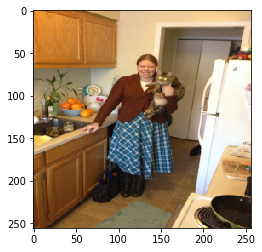

A girl smiles as she holds a cat and wears a brightly colored skirt.


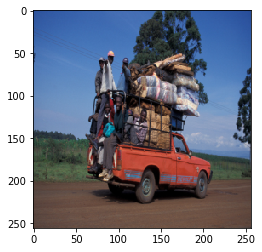

A truck with a number of people and things in the back


In [18]:
# imagens e legenda
print(next(iter(train_loader))[0].shape)
from matplotlib import pyplot as plt
examples = next(iter(train_loader))
for i in range(0,2):
  plt.imshow(examples[0][i].numpy().transpose(1, 2, 0), interpolation='nearest')
  plt.show()
  print(examples[1][i])

In [19]:
# tokens
print(examples[2].shape)
examples[2]

torch.Size([5, 1, 32])


tensor([[[   71,  3202,  3993,     7,    38,   255,  4532,     3,     9,  1712,
             11,  2112,     7,     3,     9,  2756,   120, 11999, 11028,     5,
              1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[   71,  4072,    28,     3,     9,   381,    13,   151,    11,   378,
             16,     8,   223,     1,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[   71,  3432,   423,    13,   151,    19,    30,     3,     9,  6943,
             28,  8277,     5,     1,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0]],

        [[ 2449,  7494, 12679,     7,   323,     8,  1373, 16009,     3,     9,
           5963,     5,     1,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  

# 3. Treino

In [21]:
from torch import nn
from torch import Tensor

class Model():

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()

        # camada convolucional
        self.stride = stride
        self.conv1 =      nn.Conv2d(inplanes, planes, stride=stride, bias=False, dilation=1, kernel_size=3, padding=1)
        self.bn1 =        nn.BatchNorm2d(planes)
        self.relu =       nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

In [ ]:
imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
